In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("C:/Users/b.hirs/OneDrive - Vrije Universiteit Amsterdam/School/Block 3/Case study/data/result_gemeente_eng.csv")

# Review data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508 entries, 0 to 6507
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6508 non-null   int64  
 1   last_scraped                 6508 non-null   object 
 2   host_id                      6508 non-null   int64  
 3   host_since                   6508 non-null   object 
 4   host_is_superhost            6508 non-null   int64  
 5   neighbourhood_cleansed       6508 non-null   object 
 6   host_listings_count          6508 non-null   int64  
 7   latitude                     6508 non-null   float64
 8   longitude                    6508 non-null   float64
 9   property_type                6508 non-null   object 
 10  room_type                    6508 non-null   object 
 11  accommodates                 6508 non-null   int64  
 12  bathrooms                    6508 non-null   float64
 13  bathrooms_text    

In [5]:
# Convert distance columns to float
distance_columns = [
    'trainstation_distance', 'amusement_park_distance', 'swimming_pool_distance',
    'cinema_distance', 'museum_distance',  'supermarket_distance', 'cafe_distance', 'hotel_distance', 'restaurant_distance',
]
for column in distance_columns:
    df[column] = df[column].str.replace(',', '.').astype(float)

In [6]:
df = df.dropna()

# Apply log transformation to the target variable optional
# df['logprice'] = np.log(df['price'])

# One hot encoding for property category
df = pd.get_dummies(df, columns=['property_category'], prefix=['type'])

# Separate target and features
y = df['price']

features = ["host_is_superhost", "accommodates", "bathrooms", "bedrooms", "beds",
            "number_of_reviews", "review_scores_rating", 'Dishwasher', 'Washer', 'Dryer', 'Microwave',
            'Freezer', 'Private entrance', 'Coffee maker', 'Oven', 'Outdoor dining area', 'Private patio or balcony',
            'Luggage dropoff allowed', 'Bathtub', 'Blender', 'Paid parking on premises',
            'Air conditioning', 'Waterfront', 'Pets allowed', 'Canal view', 'Free parking on premises', 'Bikes', 'Safe',
            "residents", "average_household_income", "average_house_value", "supermarket_distance", "cafe_distance",
            "hotel_distance", "restaurant_distance", "trainstation_distance", "amusement_park_distance",
            "swimming_pool_distance", "cinema_distance", "museum_distance",
            'distance_to_city_center', "type_PRIVATE_ROOM", "type_WHOLE_PROPERTY"]
X = df[features]

# Convert categorical variables to dummy variables
categorical_columns = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6493 entries, 0 to 6507
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6493 non-null   int64  
 1   last_scraped                 6493 non-null   object 
 2   host_id                      6493 non-null   int64  
 3   host_since                   6493 non-null   object 
 4   host_is_superhost            6493 non-null   int64  
 5   neighbourhood_cleansed       6493 non-null   object 
 6   host_listings_count          6493 non-null   int64  
 7   latitude                     6493 non-null   float64
 8   longitude                    6493 non-null   float64
 9   property_type                6493 non-null   object 
 10  room_type                    6493 non-null   object 
 11  accommodates                 6493 non-null   int64  
 12  bathrooms                    6493 non-null   float64
 13  bathrooms_text         

### 2. Lasso regression

In [8]:
# Define directories for figures and exports
figures_dir = r"C:/Users/b.hirs/OneDrive - Vrije Universiteit Amsterdam/School/Block 3/Case study/figs"
exports_dir = r"C:/Users/b.hirs/OneDrive - Vrije Universiteit Amsterdam/School/Block 3/Case study/Exports"

In [9]:
# 1) Extract numeric columns from df
numeric_df = df.select_dtypes(include=[float, int, 'bool']).copy()

# 2) Verify the 'price' column is among them
if 'price' not in numeric_df.columns:
    raise ValueError("The 'price' column is not numeric or not in df. Check your data cleaning.")

# 3) Drop rows with NaNs in any numeric column (including 'price')
numeric_df.dropna(inplace=True)

# 4) Separate features (X) and target (y)
X = numeric_df.drop(columns=['price'])  
y = numeric_df['price']                

print("Number of features:", X.shape[1])
print("Number of samples:", X.shape[0])

Number of features: 58
Number of samples: 6493


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,     # 20% test, 80% train
    random_state=42    # seed 
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (5194, 58)
Test set size: (1299, 58)


In [11]:
scaler = StandardScaler()

# Fit on the training set and transform
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Define a range of alphas to try
alpha_range = np.logspace(-3, 1, 50)

# Create the LassoCV model (uses cross-validation internally)
lasso_model = LassoCV(
    alphas=alpha_range,
    cv=5,            # 5-fold cross-validation
    random_state=42  # seed
)

# Fit the model
lasso_model.fit(X_train_scaled, y_train)

print("Best alpha chosen by LassoCV:", lasso_model.alpha_)

c:\Users\b.hirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18427.875362969935, tolerance: 8762.007701419978
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\b.hirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16491.370069004595, tolerance: 9000.148286064985
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\b.hirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11181.216118305922, tolerance: 8513.507450445246
  model = cd_fast.enet_coordinate_descent_gram

Best alpha chosen by LassoCV: 0.0517947467923121


c:\Users\b.hirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.707e+04, tolerance: 1.092e+04
  model = cd_fast.enet_coordinate_descent(


In [13]:
# Predict on training and test sets
y_pred_train = lasso_model.predict(X_train_scaled)
y_pred_test = lasso_model.predict(X_test_scaled)

# Calculate R^2
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Calculate RMSE
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test  = np.sqrt(mse_test)

print(f"TRAIN R^2:  {r2_train:.3f}")
print(f"TRAIN RMSE: {rmse_train:.2f}")
print("-------------------------")
print(f"TEST R^2:   {r2_test:.3f}")
print(f"TEST RMSE:  {rmse_test:.2f}")

TRAIN R^2:  0.536
TRAIN RMSE: 98.83
-------------------------
TEST R^2:   0.513
TEST RMSE:  95.42


In [14]:
# Generate LaTeX content for the results
latex_content = f"""
\\documentclass{{article}}
\\usepackage{{amsmath}}
\\begin{{document}}

\\section*{{Lasso Regression Performance Metrics}}

\\subsection*{{Training Set}}
\\begin{{itemize}}
    \\item $R^2$: {r2_train:.3f}
    \\item RMSE: {rmse_train:.2f}
\\end{{itemize}}

\\subsection*{{Test Set}}
\\begin{{itemize}}
    \\item $R^2$: {r2_test:.3f}
    \\item RMSE: {rmse_test:.2f}
\\end{{itemize}}

\\end{{document}}
"""

# File path for the LaTeX export
latex_file_path = os.path.join(exports_dir, "lasso_performance_metrics.tex")

# Write the LaTeX content to the file
with open(latex_file_path, "w") as file:
    file.write(latex_content)

print(f"LaTeX file exported to: {latex_file_path}")

LaTeX file exported to: C:/Users/b.hirs/OneDrive - Vrije Universiteit Amsterdam/School/Block 3/Case study/Exports\lasso_performance_metrics.tex


In [15]:
coef_dict = {
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
}
coef_df = pd.DataFrame(coef_dict).sort_values('Coefficient', ascending=False)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Lasso Coefficients:")
print(coef_df)


Lasso Coefficients:
                        Feature  Coefficient
6                  accommodates      45.8177
13    review_scores_cleanliness      41.9983
42                   households      36.9184
8                      bedrooms      29.6875
11         review_scores_rating      25.0911
7                     bathrooms      22.3207
46          average_house_value      21.9835
48                cafe_distance      16.6356
32             Air conditioning      10.7061
43     single_person_households       9.4873
26          Outdoor dining area       8.7371
18                   Dishwasher       8.5575
29                      Bathtub       8.4426
35                   Canal view       7.1107
27     Private patio or balcony       5.9467
38                         Safe       3.8947
34                 Pets allowed       2.7620
49               hotel_distance       2.7336
19                       Washer       2.0667
55              museum_distance       1.9874
31     Paid parking on premises    

In [16]:

# 2) Calculate RSS (Residual Sum of Squares)
residuals = y_train - y_pred_train
RSS = np.sum(residuals**2)

# 3) Number of observations
n = len(y_train)

# 4) Count number of nonzero 
k = np.sum(lasso_model.coef_ != 0) + 1

# 5) Calculate AIC and BIC
AIC = n * np.log(RSS / n) + 2 * k
BIC = n * np.log(RSS / n) + k * np.log(n)

print(f"AIC : {AIC:.2f}")
print(f"BIC : {BIC:.2f}")

AIC : 47832.51
BIC : 48212.71


In [17]:
# Export Lasso Coefficients to LaTeX
coef_latex_path = os.path.join(exports_dir, "lasso_coefficients.tex")
with open(coef_latex_path, "w") as file:
    file.write(coef_df.to_latex(index=False, float_format="%.4f"))

print(f"Lasso coefficients exported to: {coef_latex_path}")


Lasso coefficients exported to: C:/Users/b.hirs/OneDrive - Vrije Universiteit Amsterdam/School/Block 3/Case study/Exports\lasso_coefficients.tex


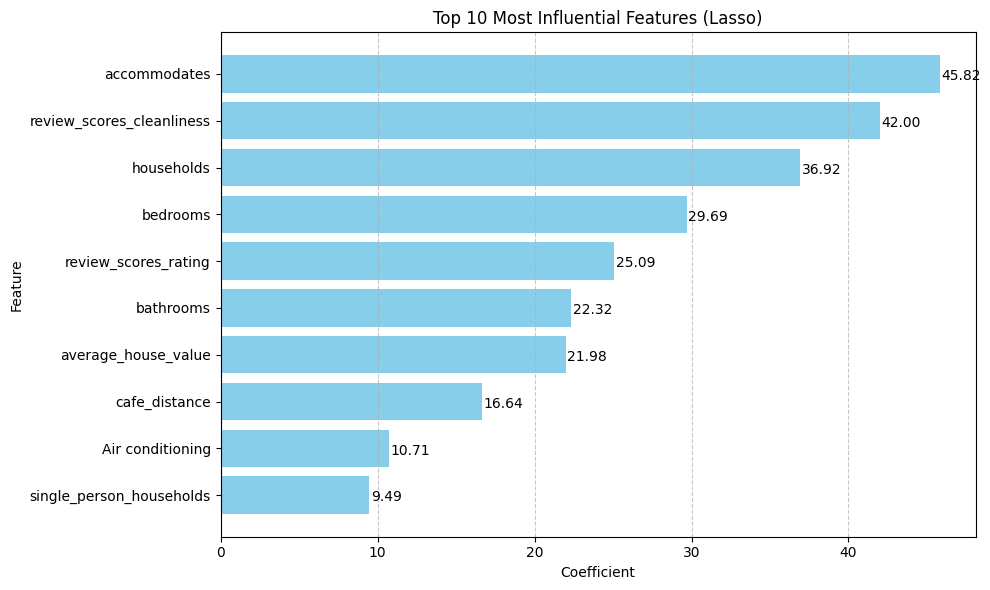

Figure saved to C:/Users/b.hirs/OneDrive - Vrije Universiteit Amsterdam/School/Block 3/Case study/figs\top10_lasso_barplot.png


In [18]:
# Take the top 10 largest positive coefficients (first 10 rows in descending order)
top10_norm = coef_df.head(10)

# Assuming you already have top10_norm defined
plt.figure(figsize=(10, 6)) 
plt.barh(
    y=top10_norm['Feature'],
    width=top10_norm['Coefficient'],
    color='skyblue',
)

# Add a title
plt.title("Top 10 Most Influential Features (Lasso)")

# Label axes
plt.xlabel("Coefficient")
plt.ylabel("Feature")

# Invert y-axis so the highest coefficient is at the top
plt.gca().invert_yaxis()

# Optional: add a grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# (Optional) Annotate each bar with its coefficient value
for i, v in enumerate(top10_norm['Coefficient']):
    plt.text(v + 0.1, i + 0.05, f"{v:.2f}", color='black', va='center')

plt.tight_layout()

# Export the figure to your exports directory
filename = "top10_lasso_barplot.png"
save_path = os.path.join(figures_dir, filename)
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

print(f"Figure saved to {save_path}")


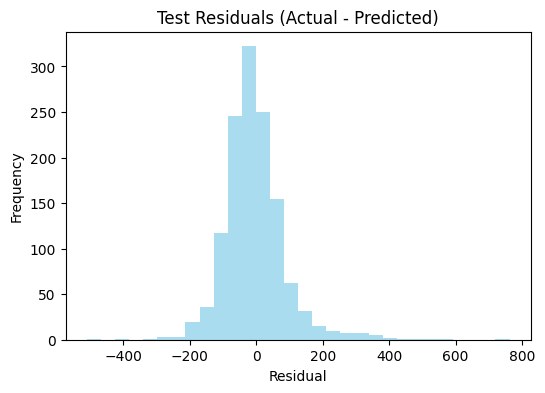

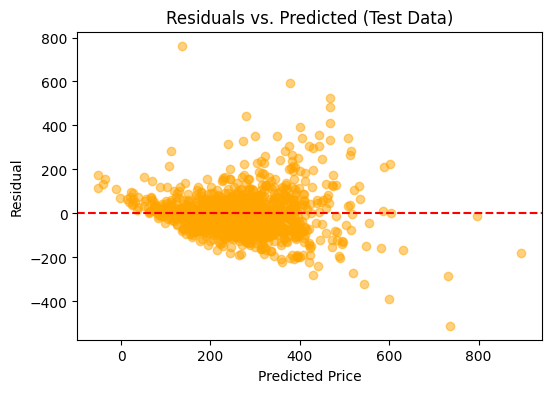

In [19]:
# Calculate residuals
residuals_test = y_test - y_pred_test

plt.figure(figsize=(6,4))
plt.hist(residuals_test, bins=30, color='skyblue', alpha=0.7)
plt.title("Test Residuals (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Residual vs. Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, residuals_test, alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted (Test Data)")
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.show()

In [20]:
ridge = RidgeCV(alphas=alpha_range, cv=5)
ridge.fit(X_train_scaled, y_train)
print("Best alpha for Ridge:", ridge.alpha_)

Best alpha for Ridge: 10.0


In [21]:
# Predict on the training set
y_pred_train_ridge = ridge.predict(X_train_scaled)
r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
rmse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge, squared=False)

# Predict on the test set
y_pred_test_ridge = ridge.predict(X_test_scaled)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)
rmse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge, squared=False)

print("RIDGE TRAIN R^2:", r2_train_ridge)
print("RIDGE TRAIN RMSE:", rmse_train_ridge)
print("-------------------------")
print("RIDGE TEST R^2:", r2_test_ridge)
print("RIDGE TEST RMSE:", rmse_test_ridge)


RIDGE TRAIN R^2: 0.5355522098274199
RIDGE TRAIN RMSE: 98.82939346842741
-------------------------
RIDGE TEST R^2: 0.5125989586222782
RIDGE TEST RMSE: 95.4244008479383


c:\Users\b.hirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\b.hirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
# Generate LaTeX content for Ridge regression performance metrics
ridge_metrics_latex_content = f"""
\\section*{{Ridge Regression Performance Metrics}}

\\subsection*{{Training Set}}
\\begin{{itemize}}
    \\item $R^2$: {r2_train_ridge:.3f}
    \\item RMSE: {rmse_train_ridge:.2f}
\\end{{itemize}}

\\subsection*{{Test Set}}
\\begin{{itemize}}
    \\item $R^2$: {r2_test_ridge:.3f}
    \\item RMSE: {rmse_test_ridge:.2f}
\\end{{itemize}}
"""

# Export Ridge performance metrics to LaTeX
ridge_metrics_latex_path = os.path.join(exports_dir, "ridge_metrics.tex")
with open(ridge_metrics_latex_path, "w") as file:
    file.write(ridge_metrics_latex_content)

print(f"Ridge metrics exported to: {ridge_metrics_latex_path}")


Ridge metrics exported to: C:/Users/b.hirs/OneDrive - Vrije Universiteit Amsterdam/School/Block 3/Case study/Exports\ridge_metrics.tex


#### Only use if running logged price

In [23]:
df['price_log'] = np.log1p(df['price'])

# 1) Extract numeric columns from df
numeric_df = df.select_dtypes(include=[float, int, 'bool']).copy()

# 2) Verify 'price' in numeric_df
if 'price' not in numeric_df.columns:
    raise ValueError("The 'price' column is not numeric or not in df. Check your data cleaning.")

# 3) Drop rows with NaNs
numeric_df.dropna(inplace=True)

# 4) Separate features (X) and target (y)
X = numeric_df.drop(columns=['price', 'price_log'], errors='ignore')
y = numeric_df['price_log']

print("Number of features:", X.shape[1])
print("Number of samples:", X.shape[0])

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alpha_range = np.logspace(-3, 1, 50)
lasso_model = LassoCV(alphas=alpha_range, cv=5, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

print("Best alpha chosen by LassoCV:", lasso_model.alpha_)

y_pred_train = lasso_model.predict(X_train_scaled)
y_pred_test = lasso_model.predict(X_test_scaled)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test  = np.sqrt(mse_test)

print(f"TRAIN R^2:  {r2_train:.3f}")
print(f"TRAIN RMSE: {rmse_train:.2f}")
print("-------------------------")
print(f"TEST R^2:   {r2_test:.3f}")
print(f"TEST RMSE:  {rmse_test:.2f}")

coef_dict = {
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
}
coef_df = pd.DataFrame(coef_dict).sort_values('Coefficient', ascending=False)


print("Lasso Coefficients:")
print(coef_df)


Number of features: 58
Number of samples: 6493
Training set size: (5194, 58)
Test set size: (1299, 58)
Best alpha chosen by LassoCV: 0.001
TRAIN R^2:  0.587
TRAIN RMSE: 0.34
-------------------------
TEST R^2:   0.579
TEST RMSE:  0.33
Lasso Coefficients:
                        Feature  Coefficient
6                  accommodates       0.1650
13    review_scores_cleanliness       0.1126
8                      bedrooms       0.0964
43     single_person_households       0.0826
7                     bathrooms       0.0477
46          average_house_value       0.0449
48                cafe_distance       0.0423
18                   Dishwasher       0.0409
32             Air conditioning       0.0377
26          Outdoor dining area       0.0346
35                   Canal view       0.0253
29                      Bathtub       0.0234
27     Private patio or balcony       0.0226
11         review_scores_rating       0.0149
34                 Pets allowed       0.0115
38                       

In [24]:
# Export Lasso Coefficients
coef_latex_path = os.path.join(exports_dir, "lasso_coefficients_log.tex")
with open(coef_latex_path, "w") as file:
    file.write(coef_df.to_latex(index=False, float_format="%.4f"))

print(f"Lasso coefficients exported to: {coef_latex_path}")


Lasso coefficients exported to: C:/Users/b.hirs/OneDrive - Vrije Universiteit Amsterdam/School/Block 3/Case study/Exports\lasso_coefficients_log.tex


In [25]:
# Generate LaTeX content for performance metrics
metrics_latex_content = f"""
\\section*{{Lasso Regression Performance Metrics}}

\\subsection*{{Training Set}}
\\begin{{itemize}}
    \\item $R^2$: {r2_train:.3f}
    \\item RMSE: {rmse_train:.2f}
\\end{{itemize}}

\\subsection*{{Test Set}}
\\begin{{itemize}}
    \\item $R^2$: {r2_test:.3f}
    \\item RMSE: {rmse_test:.2f}
\\end{{itemize}}
"""

# Export Performance Metrics
metrics_latex_path = os.path.join(exports_dir, "lasso_metrics_log.tex")
with open(metrics_latex_path, "w") as file:
    file.write(metrics_latex_content)

print(f"Performance metrics exported to: {metrics_latex_path}")


Performance metrics exported to: C:/Users/b.hirs/OneDrive - Vrije Universiteit Amsterdam/School/Block 3/Case study/Exports\lasso_metrics_log.tex


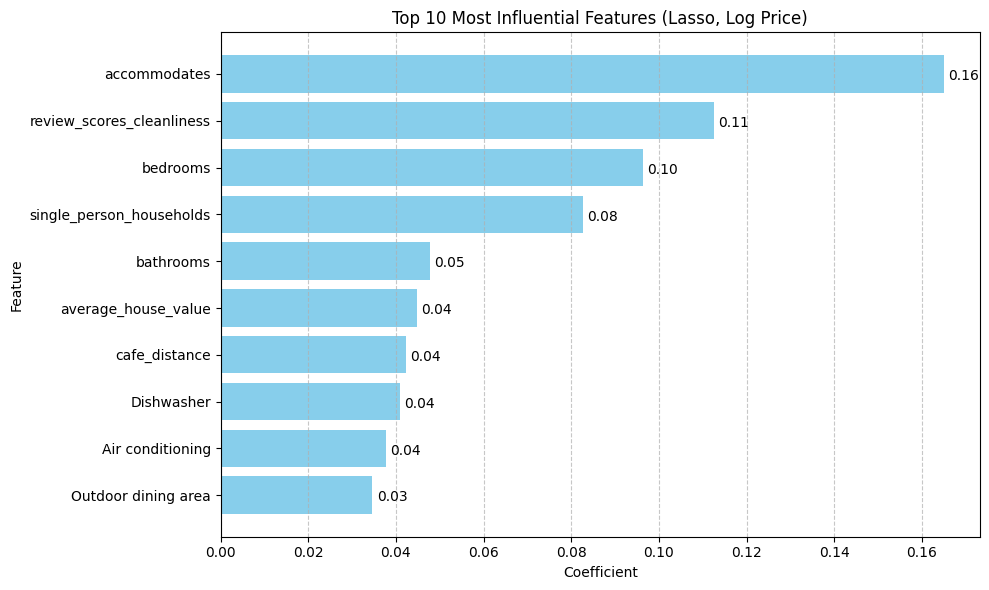

Figure saved to C:/Users/b.hirs/OneDrive - Vrije Universiteit Amsterdam/School/Block 3/Case study/figs\top10_lasso_barplot_log.png


In [26]:
# Take the top 10 largest
top10_log = coef_df.head(10)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(
    y=top10_log['Feature'],
    width=top10_log['Coefficient'],
    color='skyblue',
)
plt.title("Top 10 Most Influential Features (Lasso, Log Price)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Annotate each bar with its coefficient 
for i, v in enumerate(top10_log['Coefficient']):
    plt.text(v + 0.001, i + 0.05, f"{v:.2f}", color='black', va='center')

plt.tight_layout()

# Save to exports directory
filename_log = "top10_lasso_barplot_log.png"
save_path_log = os.path.join(figures_dir, filename_log)
plt.savefig(save_path_log, dpi=300, bbox_inches="tight")

plt.show()

print(f"Figure saved to {save_path_log}")


In [27]:
# 1) Predict on training set
y_pred_train = lasso_model.predict(X_train_scaled)

# 2) Calculate RSS 
residuals = y_train - y_pred_train
RSS = np.sum(residuals**2)

# 3) Number of observations
n = len(y_train)

# 4) Count number of nonzero 
k = np.sum(lasso_model.coef_ != 0) + 1

# 5) Calculate AIC and BIC
AIC = n * np.log(RSS / n) + 2 * k
BIC = n * np.log(RSS / n) + k * np.log(n)

print(f"AIC (train): {AIC:.2f}")
print(f"BIC (train): {BIC:.2f}")

AIC (train): -11145.14
BIC (train): -10823.93


In [28]:
# 1. TRAIN adjusted R^2
n_train = X_train.shape[0]
k_train = X_train.shape[1]  # total number of features (columns)
r2_train_adj = 1 - (1 - r2_train) * ((n_train - 1) / (n_train - k_train - 1))
print(f"TRAIN Adjusted R^2: {r2_train_adj:.3f}")

# 2. TEST adjusted R^2 (less common, but sometimes reported)
n_test = X_test.shape[0]
k_test = X_test.shape[1]
r2_test_adj = 1 - (1 - r2_test) * ((n_test - 1) / (n_test - k_test - 1))
print(f"TEST Adjusted R^2:  {r2_test_adj:.3f}")

TRAIN Adjusted R^2: 0.583
TEST Adjusted R^2:  0.560
